In [4]:
%matplotlib inline

from __future__ import print_function
import os
import gensim
import subprocess
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import json
from collections import Counter
from itertools import chain

Using TensorFlow backend.


In [ ]:
MODEL = 'GoogleNews-vectors-negative300.bin'
if not os.path.isfile(MODEL):
    with open(MODEL, 'wb') as fout:
        path = 'https://s3.amazonaws.com/dl4j-distribution/%s.gz' % MODEL
        curl = subprocess.Popen(['curl', path],
                                stdout=subprocess.PIPE).stdout
        zcat = subprocess.Popen(['zcat'],
                          stdin=curl,
                          stdout=fout
                         )
        zcat.wait()

In [9]:
model = gensim.models.KeyedVectors.load_word2vec_format(MODEL, binary=True)

In [10]:
model.most_similar(positive=['espresso'])

[('cappuccino', 0.688818633556366),
 ('mocha', 0.6686208248138428),
 ('coffee', 0.6616827249526978),
 ('latte', 0.6536752581596375),
 ('caramel_macchiato', 0.6491269469261169),
 ('ristretto', 0.6485545635223389),
 ('espressos', 0.6438629627227783),
 ('macchiato', 0.6428249478340149),
 ('chai_latte', 0.6308027505874634),
 ('espresso_cappuccino', 0.6280543804168701)]

In [11]:
def A_is_to_B_as_C_is_to(a, b, c, topn=1):
    a, b, c = map(lambda x:x if type(x) == list else [x], (a, b, c))
    res = model.most_similar(positive=b + c, negative=a, topn=topn)
    if len(res):
        if topn == 1:
            return res[0][0]
        return [x[0] for x in res]
    return None

A_is_to_B_as_C_is_to('man', 'woman', 'king')

'queen'

In [12]:
for country in 'Italy', 'France', 'India', 'China':
    print('%s is the capital of %s' % 
          (A_is_to_B_as_C_is_to('Germany', 'Berlin', country), country))

Rome is the capital of Italy
Paris is the capital of France
Delhi is the capital of India
Beijing is the capital of China


In [13]:
for company in 'Google', 'IBM', 'Boeing', 'Microsoft', 'Samsung':
    products = A_is_to_B_as_C_is_to(
        ['Starbucks', 'Apple'], 
        ['Starbucks_coffee', 'iPhone'], 
        company, topn=3)
    print('%s -> %s' % 
          (company, ', '.join(products)))

Google -> personalized_homepage, app, Gmail
IBM -> DB2, WebSphere_Portal, Tamino_XML_Server
Boeing -> Dreamliner, airframe, aircraft
Microsoft -> Windows_Mobile, SyncMate, Windows
Samsung -> MM_A###, handset, Samsung_SCH_B###


In [14]:
beverages = ['Cola', 'Coffee', 'Tea', 'Wine', 'Cappuccino', 'Latte',
             'Ginger Ale', 'Orange Juice', 'Apple Juice', 'Whiskey',
             'Vodka', 'Lager', 'Hefeweizen', 'IPA', 'Grape Juice',
             'Milk', 'Goat Milk', 'Herbal Tea']
len(beverages)

18

In [15]:
normalized = [beverage.lower().replace(' ', '_').replace('-', '_') 
              for beverage in beverages]
beverage_vectors = [(beverage, model[norm]) 
                    for beverage, norm in zip(beverages, normalized) 
                    if norm in model]
len(beverage_vectors)

18

In [16]:
vectors = np.asarray([x[1] for x in beverage_vectors])
lengths = np.linalg.norm(vectors, axis=1)
vectors = (vectors.T / lengths).T

tsne = TSNE(n_components=2, perplexity=10, verbose=2).fit_transform(vectors)

[t-SNE] Computing pairwise distances...
[t-SNE] Computing 17 nearest neighbors...
[t-SNE] Computed conditional probabilities for sample 18 / 18
[t-SNE] Mean sigma: 0.422394
[t-SNE] Iteration 25: error = 1.0797015, gradient norm = 0.0024558
[t-SNE] Iteration 50: error = 1.0067117, gradient norm = 0.0021012
[t-SNE] Iteration 75: error = 0.8328501, gradient norm = 0.0010670
[t-SNE] Iteration 100: error = 0.8005741, gradient norm = 0.0010775
[t-SNE] KL divergence after 100 iterations with early exaggeration: 0.800574
[t-SNE] Iteration 125: error = 0.7054098, gradient norm = 0.0013243
[t-SNE] Iteration 150: error = 0.6558407, gradient norm = 0.0012816
[t-SNE] Iteration 175: error = 0.6433069, gradient norm = 0.0012577
[t-SNE] Iteration 200: error = 0.6396095, gradient norm = 0.0012476
[t-SNE] Iteration 225: error = 0.6385924, gradient norm = 0.0012446
[t-SNE] Iteration 250: error = 0.6383104, gradient norm = 0.0012438
[t-SNE] Iteration 275: error = 0.6382326, gradient norm = 0.0012436
[t-SN

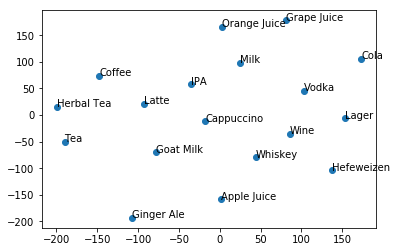

In [17]:
x=tsne[:,0]
y=tsne[:,1]

fig, ax = plt.subplots()
ax.scatter(x, y)

for bev, x1, y1 in zip(beverage_vectors, x, y):
    ax.annotate(bev[0], (x1, y1))

plt.show()

In [18]:
x.min(), x.max()

(-199.45668520670424, 173.1036072377226)

In [19]:
model.most_similar(positive=['tea',], topn=10)

[('Tea', 0.700903594493866),
 ('teas', 0.6727380752563477),
 ('shape_Angius', 0.6323481202125549),
 ('activist_Jamie_Radtke', 0.5863860249519348),
 ('decaffeinated_brew', 0.5839537382125854),
 ('planter_bungalow', 0.5758289694786072),
 ('herbal_tea', 0.5731173753738403),
 ('coffee', 0.5635291934013367),
 ('jasmine_tea', 0.5483392477035522),
 ('Tea_NASDAQ_PEET', 0.5402543544769287)]

In [22]:
tweets = json.load(open('data/condensed_2017.json'))
tokenized = [list(gensim.utils.tokenize(tweet['text'])) for tweet in tweets]

In [23]:
word_counts = Counter(chain(*tokenized))
word_weights = {word: 1.0 / weight for word, weight in word_counts.items()}
[(x[0], word_weights[x[0]]) for x in word_counts.most_common(10)]

[('the', 0.0013812154696132596),
 ('to', 0.002066115702479339),
 ('and', 0.00267379679144385),
 ('t', 0.002717391304347826),
 ('of', 0.0030959752321981426),
 ('https', 0.0031847133757961785),
 ('co', 0.003257328990228013),
 ('in', 0.003663003663003663),
 ('a', 0.00411522633744856),
 ('is', 0.004273504273504274)]

In [25]:
def tweet_vector(tweet):
    res = None
    weight = 0
    for word in tweet:
        if not word in model:
            continue
        vector = model[word] * word_weights[word]
        if res is None:
            res = vector
        else:
            res += vector
    if np.linalg.norm(res) == 0:
        return None # No real information
    return res / np.linalg.norm(res)

tweet_vectors = [tweet_vector(tweet) for tweet in tokenized]

In [26]:
usuable_tweets = []
usuable_vectors = []
for tweet, vector in zip(tweets, tweet_vectors):
    if not vector is None:
        usuable_tweets.append(tweet['text'])
        usuable_vectors.append(vector)
usuable_vectors = np.asarray(usuable_vectors)

In [142]:
def closest(word):
    dists = np.dot(usuable_vectors, model[word])
    return np.argsort(dists)[-10:]

word = 'music'
print('Matches for: %s' % word)
print('---')
for other_idx in closest(word):
    print(usuable_tweets[other_idx])


Matches for: music
---
Great parent-teacher listening session this morning with @VP Pence &amp; @usedgov Secretary @BetsyDeVos. Watch:… https://t.co/nuLTs513Ot
My statement as to what's happening in Sweden was in reference to a story that was broadcast on @FoxNews concerning immigrants &amp; Sweden.
Is it true the DNC would not allow the FBI access to check server or other equipment after learning it was hacked? Can that be possible?
Join me live at 9:00 P.M. 
#JointAddress https://t.co/J882zbyVkJ https://t.co/gTtK3vJmkU
Join me live from the @WhiteHouse.
https://t.co/LHOs4nAaGl
Join me live at the @WhiteHouse.

➡️https://t.co/9VOb99W42r https://t.co/sjb5VHLHYH
Looking forward to a big rally in Nashville, Tennessee, tonight. Big crowd of great people expected. Will be fun!
Nancy Pelosi and Fake Tears Chuck Schumer held a rally  at the steps of The Supreme Court and mic did not work (a mess)-just like Dem party!
Great Concert at 4:00 P.M. today at Lincoln Memorial. Enjoy!
Jackie Evancho

In [137]:
np.dot([usuable_vectors[tweet_idx]], usuable_vectors[tweet_idx])

array([ 1.00000012], dtype=float32)

In [18]:
vectors

array([[-0.06258024, -0.02259842,  0.00987693, ...,  0.07553878,
         0.03745333,  0.03729529],
       [-0.05390024, -0.04573354, -0.12478722, ...,  0.0220501 ,
         0.07284699,  0.0676203 ],
       [-0.06273787,  0.03928446, -0.01487826, ...,  0.10612667,
         0.02154782,  0.10143599],
       ..., 
       [-0.02361988,  0.04283071, -0.00225373, ...,  0.07684333,
         0.03054837, -0.08188223],
       [ 0.00513691, -0.06047985, -0.01602458, ...,  0.0267507 ,
         0.07185213,  0.03928606],
       [-0.09418097, -0.03064828, -0.00470247, ...,  0.14100839,
         0.07313494,  0.0799749 ]], dtype=float32)

In [29]:
[sum(x[1]) for x in beverage_vectors]

[-4.626129150390625,
 -3.6992340087890625,
 -5.369544506072998,
 -1.5804328918457031,
 0.10629653930664062,
 -1.9902725219726562,
 -4.2095489501953125,
 -0.2247772216796875,
 -3.1390838623046875,
 -0.80577659606933594,
 3.6111221313476562,
 -1.7716903686523438,
 -2.0825843811035156,
 1.348358154296875,
 -1.8843193054199219,
 -2.0873260498046875,
 1.33062744140625,
 -7.1678543090820312]

In [32]:
beverage_vectors[0][1]

array([-0.19335938, -0.06982422,  0.03051758,  0.57421875, -0.00463867,
        0.0246582 ,  0.328125  , -0.1796875 ,  0.04711914,  0.2265625 ,
       -0.04858398, -0.22949219, -0.13671875,  0.10839844, -0.41210938,
        0.4140625 , -0.01416016,  0.05957031,  0.07568359, -0.16308594,
       -0.12011719,  0.02514648,  0.04272461, -0.39257812, -0.02392578,
        0.13867188, -0.27148438,  0.16894531,  0.04492188,  0.27148438,
        0.2578125 , -0.14453125,  0.00604248,  0.12255859, -0.42773438,
       -0.19042969,  0.05834961,  0.02954102,  0.2578125 ,  0.02758789,
       -0.02941895, -0.35351562,  0.12353516,  0.13671875, -0.16699219,
       -0.15917969, -0.04882812,  0.04101562,  0.15820312, -0.02954102,
       -0.3515625 ,  0.0267334 , -0.19628906,  0.05786133,  0.08447266,
       -0.11767578,  0.26367188, -0.1328125 , -0.00958252, -0.265625  ,
        0.0300293 ,  0.015625  , -0.10302734,  0.04541016, -0.09423828,
       -0.01635742, -0.15429688,  0.01708984,  0.12304688, -0.11

In [38]:
def rank_beverages(beverage, topn=10):
    for other in beverage_vectors:
        if other[0].lower() == beverage.lower():
            vec = other[1]
            dists = np.dot(vectors, vec)
            return [(beverage_vectors[idx][0], float(dists[idx])) 
                    for idx in reversed(np.argsort(dists)[-topn:])]
    return []

rank_beverages('ipa')

[('IPA', 2.0834081172943115),
 ('Hefeweizen', 0.4371369183063507),
 ('Cola', 0.42915797233581543),
 ('Latte', 0.3974763751029968),
 ('Herbal Tea', 0.3242728114128113),
 ('Cappuccino', 0.3090534806251526),
 ('Goat Milk', 0.3050992488861084),
 ('Grape Juice', 0.28654414415359497),
 ('Milk', 0.27041053771972656),
 ('Coffee', 0.2670033872127533)]